In [1]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 2.2 MB/s            


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2022-01-17 13:12:30.460903: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/catkin_ws/devel/lib:/opt/ros/noetic/lib
2022-01-17 13:12:30.460939: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.6.0


In [3]:
df = pd.read_csv('training_data.csv')

In [4]:
df.head()

,base_speed,distance_from_wall,rotation_angle,distance_setpoint,docking_time,docking_distance
0,2.8,399.134182,0.030760,500.0,11.733102,1836.0
1,2.8,763.788272,0.041003,500.0,7.800361,1266.0
2,2.8,919.541755,0.005128,500.0,18.480375,2830.0
3,2.8,266.442650,-0.005128,500.0,15.054149,2356.0
4,2.8,707.218416,0.076772,500.0,6.391310,1090.0


In [5]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

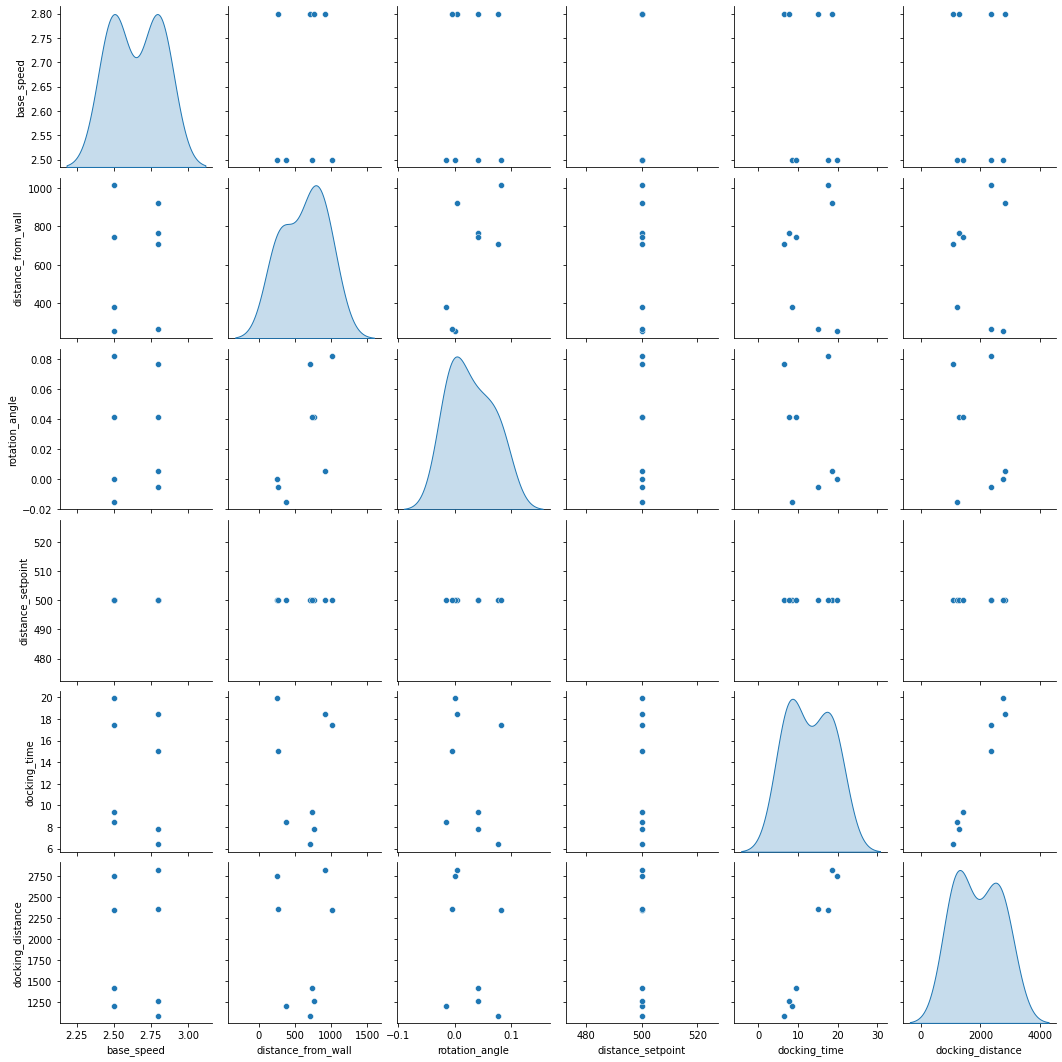

In [6]:
plot=sns.pairplot(train_dataset[['base_speed', 
                            'distance_from_wall', 
                            'rotation_angle', 
                            'distance_setpoint', 
                            'docking_time', 
                            'docking_distance']], 
                            diag_kind='kde'
                            )

In [8]:
plot.savefig('/images/seaborn.png')

FileNotFoundError: [Errno 2] No such file or directory: '/images/seaborn.png'

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
base_speed,8.0,2.650000,0.160357,2.500000,2.500000,2.650000,2.800000,2.800000
distance_from_wall,8.0,632.192293,292.917048,258.000000,354.080491,725.511749,802.726643,1015.449061
rotation_angle,8.0,0.028158,0.037617,-0.015383,-0.001282,0.023065,0.049945,0.081868
distance_setpoint,8.0,500.000000,0.000000,500.000000,500.000000,500.000000,500.000000,500.000000
docking_time,8.0,12.865340,5.437762,6.391310,8.265750,12.210340,17.743773,19.910878
docking_distance,8.0,1909.750000,734.195138,1090.000000,1252.000000,1883.000000,2457.000000,2830.000000


In [12]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('docking_distance')
t=train_features.pop('docking_time')

test_labels = test_features.pop('docking_distance')
t=test_features.pop('docking_time')

# Normalization

In [13]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
base_speed,2.650000,0.160357
distance_from_wall,632.192293,292.917048
rotation_angle,0.028158,0.037617
distance_setpoint,500.000000,0.000000
docking_time,12.865340,5.437762
docking_distance,1909.750000,734.195138


In [14]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [15]:
normalizer.adapt(np.array(train_features))

2022-01-17 13:13:44.627234: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/catkin_ws/devel/lib:/opt/ros/noetic/lib
2022-01-17 13:13:44.627315: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-17 13:13:44.627352: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-01-17 13:13:44.628394: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-17 13:13:44.726870: I tensorflow/comp

In [16]:
print(normalizer.mean.numpy())

[[  2.65  632.192   0.028 500.   ]]


# Regresja liniowa

In [20]:
distance_from_wall = np.array(train_features['distance_from_wall'])

dfw_normalizer = layers.Normalization(input_shape=[1,], axis=None)
dfw_normalizer.adapt(distance_from_wall)

In [21]:
dfw_model = tf.keras.Sequential([
    dfw_normalizer,
    layers.Dense(units=1)
])

dfw_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [22]:
dfw_model.predict(distance_from_wall[:5])

array([[ 1.037],
       [-1.35 ],
       [ 0.271],
       [-0.898],
       [ 0.475]], dtype=float32)

In [23]:
dfw_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [56]:
history = dfw_model.fit(
    train_features['distance_from_wall'],
    train_labels, 
    epochs=2000, 
    verbose=0, 
    validation_split=0.01
)

In [64]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch 
hist.tail()

,loss,val_loss,epoch
1995,889.263000,2620.786377,1995
1996,889.143982,2620.819824,1996
1997,889.024841,2620.853271,1997
1998,888.905823,2620.886719,1998
1999,888.786804,2620.920410,1999


In [65]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2500])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

In [66]:
test_results = {}
test_results['distance_from_wall'] = dfw_model.evaluate(
    test_features['distance_from_wall'],
    test_labels, verbose=0
)

In [71]:
x = tf.linspace(250, 750, 300)
y = dfw_model.predict(x)

In [72]:
def plot_dfw(x,y):
    plt.scatter(train_features['distance_from_wall'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('distance_from_wall')
    plt.ylabel('Docking distance')
    plt.legend()

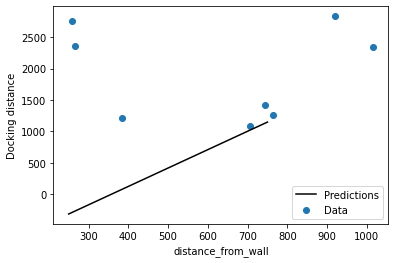

In [73]:
plot_dfw(x,y)

# Linear regression with multiple inputs

In [74]:
linear_model = tf.keras.Sequential([
    normalizer, 
    layers.Dense(units=1)
])

In [75]:
linear_model.predict(train_features[:10])

array([[-0.342],
       [-1.001],
       [ 0.526],
       [-0.946],
       [-0.057],
       [ 1.336],
       [ 3.022],
       [-2.538]], dtype=float32)

In [76]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[-0.727],
       [ 0.83 ],
       [ 0.743],
       [-0.361]], dtype=float32)>

In [77]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [78]:
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

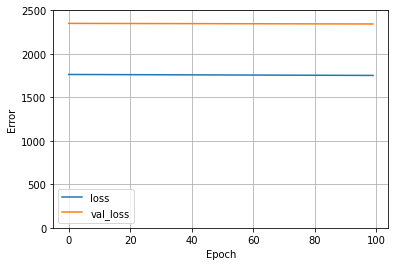

In [79]:
plot_loss(history)

In [80]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

# Regression with a deep neural network (DNN)

In [81]:
def build_and_compile(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'), 
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))

    return model

## Multiple inputs

In [82]:
dnn_model = build_and_compile(normalizer)
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [83]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 2.2 s, sys: 167 ms, total: 2.37 s
Wall time: 2.04 s


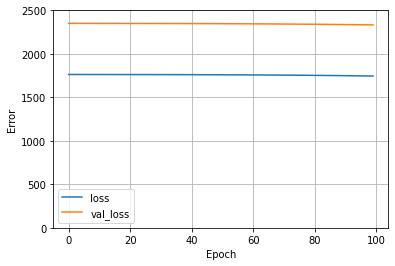

In [84]:
plot_loss(history)

In [ ]:
test_results['dnn_model']